In [1]:
 #from datetime import datetime
import numpy as np
import pandas as pd
%matplotlib inline


In [2]:
df = pd.read_csv('txn-demand-27611782.csv',  parse_dates=[5])
df.head()

,part,prefix,warehouse_code,req_qty,res_qty,demand_date
0,402066352R,RE,27611782,2,2,2019-09-02
1,410601073R,RE,27611782,1,1,2019-09-02
2,440607091R,RE,27611782,1,1,2019-09-02
3,152089599R,RE,27611782,1,1,2019-09-02
4,110265505R,RE,27611782,1,1,2019-09-02


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483409 entries, 0 to 483408
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   part            483409 non-null  object        
 1   prefix          483409 non-null  object        
 2   warehouse_code  483409 non-null  int64         
 3   req_qty         483409 non-null  int64         
 4   res_qty         483409 non-null  int64         
 5   demand_date     483409 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 22.1+ MB


In [4]:
df = df.groupby(['demand_date','part'],as_index=False).agg({'req_qty': 'sum'})

In [5]:
df.head()

,demand_date,part,req_qty
0,2019-09-02,1102601M02,1
1,2019-09-02,110265505R,4
2,2019-09-02,117201627R,1
3,2019-09-02,123091465R,1
4,2019-09-02,135027147R,1


In [6]:
s=df.part.unique()
len(s)

9930

In [7]:
s

array(['1102601M02', '110265505R', '117201627R', ..., '969208208R',
       '990909667R', '998106851R'], dtype=object)

In [8]:
groupby_data=df.groupby("part")['part'].count()
groupby_data=groupby_data.sort_values(ascending=False)
groupby_data

part
7703062062    148
110265505R    128
152095084R    113
7711220016    106
7703097516     93
             ... 
7711236340      1
7711237296      1
7711238968      1
7711239101      1
01125E6011      1
Name: part, Length: 9930, dtype: int64

In [9]:
qty = 145

In [10]:
all_dataframes = {}

In [11]:
for index, value in groupby_data.items():
    if value > qty:
        df_part = df[df['part'] == index]
        df_part.set_index('demand_date', inplace=True)
        mdata_series = df_part['req_qty'].resample('MS').mean()
        mdata = mdata_series.to_frame()
        mdata.columns=['req_qty']
        mdata = mdata.bfill(axis ='rows')
        all_dataframes[index]=mdata
  

In [12]:
mdata

,req_qty
demand_date,
2019-09-01,7.181818
2019-10-01,40.300000
2019-11-01,229.458333
2019-12-01,272.736842
2020-01-01,124.409091
2020-02-01,218.750000
2020-03-01,59.285714


In [13]:
#df_part

In [14]:
#all_dataframes

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler

In [16]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [18]:
all_dataframes

{'7703062062':                 req_qty
 demand_date            
 2019-09-01     7.181818
 2019-10-01    40.300000
 2019-11-01   229.458333
 2019-12-01   272.736842
 2020-01-01   124.409091
 2020-02-01   218.750000
 2020-03-01    59.285714}

In [63]:
df=all_dataframes['7703062062']
df

,req_qty
demand_date,
2019-09-01,7.181818
2019-10-01,40.300000
2019-11-01,229.458333
2019-12-01,272.736842
2020-01-01,124.409091
2020-02-01,218.750000
2020-03-01,59.285714


In [64]:
np.array(df)

array([[  7.18181818],
       [ 40.3       ],
       [229.45833333],
       [272.73684211],
       [124.40909091],
       [218.75      ],
       [ 59.28571429]])

In [65]:
np.array(df).reshape(-1,1)


array([[  7.18181818],
       [ 40.3       ],
       [229.45833333],
       [272.73684211],
       [124.40909091],
       [218.75      ],
       [ 59.28571429]])

In [66]:
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))
df

array([[0.        ],
       [0.12471307],
       [0.83702621],
       [1.        ],
       [0.4414425 ],
       [0.79670186],
       [0.19620753]])

In [67]:
training_size = int(len(df)*0.65)
training_size

4

In [68]:
test_size = len(df) - training_size
print(test_size)
train_data,test_data = df[0:training_size,:],df[training_size:len(df),:1]
print(train_data)
print("________")
print(test_data)

3
[[0.        ]
 [0.12471307]
 [0.83702621]
 [1.        ]]
________
[[0.4414425 ]
 [0.79670186]
 [0.19620753]]


In [88]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	print("maxlength",len(dataset)-time_step-1)
	for i in range(len(dataset)-time_step):
# 		print("i",i)
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
# 		print("dataX",dataX)
# 		print("dataY",dataY)
	return np.array(dataX), np.array(dataY)

In [89]:
n_steps = 2
X_train, y_train = create_dataset(train_data, n_steps)
X_test, y_test = create_dataset(test_data, n_steps)
print(X_train)
print("________")
print(y_train)
print("________")
print("________")
print(X_test)
print("________")
print(y_test)

maxlength 1
maxlength 0
[[0.         0.12471307]
 [0.12471307 0.83702621]]
________
[0.83702621 1.        ]
________
________
[[0.4414425  0.79670186]]
________
[0.19620753]


In [91]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2, 2)
(1, 2)
(2,)
(1,)


In [92]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print(X_train)
print(X_test)

[[[0.        ]
  [0.12471307]]

 [[0.12471307]
  [0.83702621]]]
[[[0.4414425 ]
  [0.79670186]]]


In [98]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(2,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 2, 50)             10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 2, 50)             20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,verbose=1)

Train on 2 samples, validate on 1 samples
Epoch 1/100
2/2 [==============================] - 4s 2s/sample - loss: 0.8496 - val_loss: 0.0356
Epoch 2/100
2/2 [==============================] - 0s 5ms/sample - loss: 0.8392 - val_loss: 0.0332
Epoch 3/100
2/2 [==============================] - 0s 6ms/sample - loss: 0.8285 - val_loss: 0.0307
Epoch 4/100
2/2 [==============================] - 0s 6ms/sample - loss: 0.8176 - val_loss: 0.0283
Epoch 5/100
2/2 [==============================] - 0s 6ms/sample - loss: 0.8063 - val_loss: 0.0258
Epoch 6/100
2/2 [==============================] - 0s 7ms/sample - loss: 0.7946 - val_loss: 0.0233
Epoch 7/100
2/2 [==============================] - 0s 7ms/sample - loss: 0.7823 - val_loss: 0.0208
Epoch 8/100
2/2 [==============================] - 0s 7ms/sample - loss: 0.7694 - val_loss: 0.0183
Epoch 9/100
2/2 [==============================] - 0s 6ms/sample - loss: 0.7559 - val_loss: 0.0158
Epoch 10/100
2/2 [==============================] - 0s 7ms/sample - 

2/2 [==============================] - 0s 6ms/sample - loss: 8.1992e-04 - val_loss: 1.0356
Epoch 83/100
2/2 [==============================] - 0s 6ms/sample - loss: 5.5902e-04 - val_loss: 1.0185
Epoch 84/100
2/2 [==============================] - 0s 6ms/sample - loss: 3.4596e-04 - val_loss: 1.0014
Epoch 85/100
2/2 [==============================] - 0s 6ms/sample - loss: 1.9784e-04 - val_loss: 0.9850
Epoch 86/100
2/2 [==============================] - 0s 6ms/sample - loss: 1.1871e-04 - val_loss: 0.9699
Epoch 87/100
2/2 [==============================] - 0s 6ms/sample - loss: 1.0163e-04 - val_loss: 0.9565
Epoch 88/100
2/2 [==============================] - 0s 6ms/sample - loss: 1.3201e-04 - val_loss: 0.9451
Epoch 89/100
2/2 [==============================] - 0s 5ms/sample - loss: 1.9140e-04 - val_loss: 0.9359
Epoch 90/100
2/2 [==============================] - 0s 5ms/sample - loss: 2.6101e-04 - val_loss: 0.9290
Epoch 91/100
2/2 [==============================] - 0s 6ms/sample - loss: 3.2

In [100]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
print(train_predict)
print(test_predict)

[[0.82484317]
 [1.0038501 ]]
[[1.1742018]]


In [101]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
print(train_predict)
print(test_predict)

[[226.22305]
 [273.75925]]
[[318.997]]


In [102]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

250.19639065321937

In [103]:
math.sqrt(mean_squared_error(y_test,test_predict))

318.80080174440354

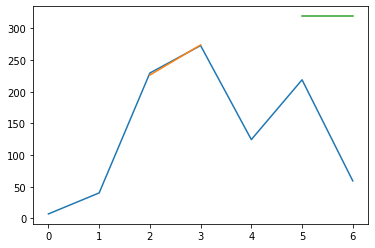

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

# shift train predictions for plotting
look_back=2
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(df), :] = test_predict
testPredictPlot[5]=318.99700928
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [113]:
print(trainPredictPlot)
print(testPredictPlot)

[[         nan]
 [         nan]
 [226.22305298]
 [273.75924683]
 [         nan]
 [         nan]
 [         nan]]
[[         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [318.99700928]]


In [1]:
for key in all_dataframes:
    # print(key, all_dataframes[key])
    df_t = all_dataframes[key]
    
    scaler=MinMaxScaler(feature_range=(0,1))
    df_t=scaler.fit_transform(np.array(df_t).reshape(-1,1))
#     print("df_t", df_t)
#     timeseries_data=df_t.req_qty.to_numpy()
    
    # choose a number of time steps
    n_steps = 2

    training_size = int(len(df_t)*0.65)
    print(training_size)
    test_size = len(df_t) - training_size
    train_data,test_data = df_t[0:training_size,:],df_t[training_size-1:len(df_t),:1]

#     print("X_train = " , X_train)
#     print("y_train = " , y_train)
#     print("X_test = " , X_test)
#     print("y_test = " , y_test)
    # split into samples
    X_train, y_train = prepare_data(train_data, n_steps)
    X_test, y_test = prepare_data(test_data, n_steps)
    
#     print(X_train)
#     print(y_train)
#     print(X_test)
#     print(y_test)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
   
    # fit model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, verbose=0)
  
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    
    print(train_predict)
    print(test_predict)
    
    import math
    from sklearn.metrics import mean_squared_error
    math.sqrt(mean_squared_error(y_train,train_predict))
    
    ### Test Data RMSE
    math.sqrt(mean_squared_error(y_test,test_predict))
    
    ## Plotting 
    # shift train predictions for plotting
    look_back=2
    trainPredictPlot = np.empty_like(df_t)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df_t)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_t)-1, :] = test_predict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(df_t))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    print(trainPredictPlot)
    print(testPredictPlot)
#     # demonstrate prediction for next 10 days
#     x_input = np.array(timeseries_data[-3:])
#     temp_input=list(x_input)
#     lst_output=[]
#     i=0
#     n=10
#     while(i<n):
#         if(len(temp_input)>3):
#             x_input=np.array(temp_input[1:])
#             print("{} month input {}".format(i,x_input))
#             #print(x_input)
#             x_input = x_input.reshape((1, n_steps, n_features))
#             #print(x_input)
#             yhat = model.predict(x_input, verbose=0)
#             print("{} month output {}".format(i,yhat))
#             temp_input.append(yhat[0][0])
#             temp_input=temp_input[1:]
#             #print(temp_input)
#             lst_output.append(yhat[0][0])
#             i=i+1
#         else:
#             x_input = x_input.reshape((1, n_steps, n_features))
#             yhat = model.predict(x_input, verbose=0)
#             print(yhat[0])
#             temp_input.append(yhat[0][0])
#             lst_output.append(yhat[0][0])
#             i=i+1
    

#     print(lst_output)
    
    
    
    
    

NameError: name 'all_dataframes' is not defined

# Visualizaing The Output

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
day_new=np.arange(1,10)
day_pred=np.arange(10,20)

In [19]:
timeseries_data

array([  7.18181818,  40.3       , 229.45833333, 272.73684211,
       124.40909091, 218.75      ,  59.28571429])

In [20]:
lst_output

[262.05286,
 635.3066,
 413.01193,
 321.39294,
 279.67416,
 136.86084,
 171.20644,
 64.04886,
 144.49939,
 211.03458]

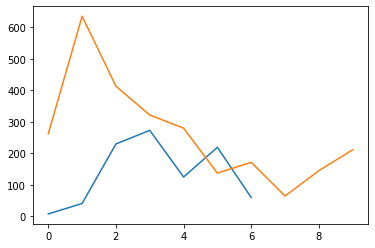

In [21]:
plt.plot(timeseries_data)
plt.plot(lst_output)